### Python Code for LSM Algorithm: American Option Pricing

In [27]:
import numpy as np
import math
from scipy.special import eval_laguerre
import matplotlib.pyplot as plt

In [10]:
def laguerre_basis(x,degree):
    '''
    
    Generate a basis of Laguerre Polynomials on X of degree k using built-in scipy functionality
    
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.eval_laguerre.html#scipy.special.eval_laguerre
    
    Allows for computation of higher order than degree 5 (orig blocker)
    
    '''
    elem=[]
    for i in range (0,degree+1):
        laguerre_i=eval_laguerre(i,x)
        elem.append(laguerre_i)
    basis=np.array(elem).reshape(i+1,len(x)).T
    return basis
                                

### Investigate numerical issues when computing basis values

In [14]:
def internal_laguerre_basis(x,degree):
    '''
    
    Generate a basis of Laguerre Polynomials on X of degree k using built-in scipy functionality
    
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.eval_laguerre.html#scipy.special.eval_laguerre
    
    Allows for computation of higher order than degree 5 (orig blocker)
    
    '''
    if degree!=2:
        return None
    else:
        basis=np.concatenate([np.ones(len(x)),1-x,0.5*(2-4*x+x**2)]).reshape(degree+1,len(x)).T
        
    return basis

In [15]:
a=np.random.rand(1000)


In [16]:
b=internal_laguerre_basis(a,2)


In [17]:
basis=laguerre_basis(a,2)


In [18]:
np.sum(abs(b-basis))

9.131584377541913e-15

### Example Laguerre Basis (scipy)

In [19]:
basis=laguerre_basis(np.ones(10),4)
basis


array([[ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ],
       [ 1.        ,  0.        , -0.5       , -0.66666667, -0.625     ]])

### Investigate in OLS solvers between numpy and matlab

### Algorithm

General understanding of the idea atm

- Use of Brownian motion to generate endpoints (interpret probability distribution of outcomes)
- Assume a brownian bridge to occur at each endpoint (constrains starting point to be same as end point, 0 when standardardized) 
    - Sample Brownian Bridge backwards in time; note intermediate points follow a distribution according to the original brownian motion
- For each itm brownian bridge at time $t_i$ compute it's current exercise value in relation to continuation
- Payoff matrix is saved as 
    - Exercise Value if is newly decided to be an optimally executed
    - Discounted final payoff else
    
- Each iteration we then either
    - Discount the optimal exercise value
    - Continue discounting the final payoff
    
- Note style of dynamic programming is embedded within the backwards iteration
- "rest" matrix only accounts for realizations that are new to optimally exercise
- Say instead this was a global array; what we would do is not update exercise values prior to latest optimal exercise; skewing the current value and ignoring dp step

In [21]:
def LSM(T,r,sigma,K,S0,N,M,k,seed=1234):
    '''
    Longstaff-schwartz method: Gustafsson Implementation
    
    T: Expiration Time 
    r: interest rate
    sigma: underlying vol
    K: strike
    S0: inital underlying
    N: # timesteps from t=0 to t=T
    M: # realizations (even)
    k: basis functions
    seed: random seed for reproducibility
    '''
    
    np.random.seed(seed)
    t=np.arange(0,T,T/N)
   
    z=np.random.normal(size=(math.floor(M/2),1))
    w=(r-(sigma**2/2))*T+sigma*np.sqrt(T)*np.vstack([z,-z]) # underlying appreciates at rate w 
    S=S0*np.exp(w) # endpoints 
    
    P=np.maximum.reduce([K-S,np.zeros(S.shape)]).reshape(1,-1)[0] # payoffs
    
    for i in range(N-2,0,-1): #step backwards in time from indices to start
        
       
        z=np.random.normal(size=(math.floor(M/2),1))
        
        # brownian bridge sampling 
        w=(t[i]*w)/t[i+1] +sigma*np.sqrt((T/N)*t[i]/t[i+1])*np.vstack([z,-z])
        
        S=S0*np.exp(w) # simulate backwards one time step 
        
        itmP=np.where(K>S)[0] # numerical indices of paths itm -> later mapped to brownian bridges 

        
        X=S[itmP].reshape(1,-1)[0] # price realizations that are itm 
        
        
        Y=P[itmP]*np.exp(-r*T/N).reshape(1,-1)[0] # discounted payoffs itm
        
        A=laguerre_basis(X,k) # generate basis functions operated on itm prices 
        
        x,resid,rank,s=np.linalg.lstsq(A,Y,rcond=None) 
      
        
        # regression using ols
        # assumes discounted payoffs is linear in laguerre functions
        
        C=A.dot(x.reshape(1,-1)[0])
        
        # for each itm price compute it's LS estimated continuation
        # note this isn't true continuation value just an estimate 
        
        
        E=(K-X) # immediate exercise value of itm options
        
        exP=np.where(C<E)[0] #  numerical indices of itmp options better to immediate exercise
        itmP_exP=itmP[exP] # respective indices in original paths 
        
        
        rest=np.setdiff1d(np.arange(0,M),itmP_exP) # the new realizations in which it is optimal to exercise 
        
        P[itmP_exP]= E[exP] # set payoff for paths where we exercised
        
        P[rest]=P[rest]*np.exp(-r*T/N) # discount asset and iterate backwards for continuation
        
        
    u=np.mean(P*np.exp(-r*T/N)) # option value
    
    return u

### Comparison against Gustaffson Tests

In [25]:
T=1
r=0.03
sigma=0.15
K=100
S0=90
N=[10+i*5 for i in range(0,39)]
M=10000
k=[2,3,4]

vals=[]
for t in N:
    bs=[]
    for b in k:
        
        lsm=LSM(T,r,sigma,K,S0,t,M,b)
        vals.append(lsm)
        bs.append(lsm)
    print(f"Average for {t} is {np.mean(bs)}")
    bs=[]
ans=np.mean(vals)


Average for 10 is 10.463822102647045
Average for 15 is 10.561081454549802
Average for 20 is 10.651781616217406
Average for 25 is 10.63685137394201
Average for 30 is 10.632998013279535
Average for 35 is 10.66162621439734
Average for 40 is 10.67990514665974
Average for 45 is 10.740693007678402
Average for 50 is 10.752426214030763
Average for 55 is 10.77907510820276
Average for 60 is 10.77520783509466
Average for 65 is 10.789778698523058
Average for 70 is 10.789906553607826
Average for 75 is 10.78522981263383
Average for 80 is 10.792925325648866
Average for 85 is 10.786245223579762
Average for 90 is 10.765526874002754
Average for 95 is 10.736185063293197
Average for 100 is 10.725147755008598
Average for 105 is 10.699945426298342
Average for 110 is 10.739090891767916
Average for 115 is 10.756128893374326
Average for 120 is 10.760682100155895
Average for 125 is 10.769223675923234
Average for 130 is 10.774470639654924
Average for 135 is 10.7798175196642
Average for 140 is 10.778674415457061


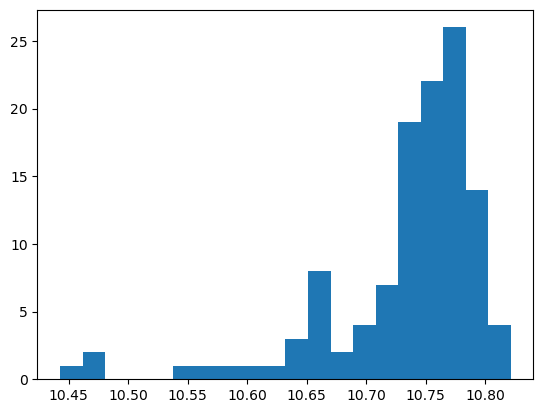

In [31]:
b=plt.hist(vals,bins=20)

In [34]:
T=1
r=0.03
sigma=0.15
K=100
S0=100
N=[10+i*5 for i in range(0,39)]
M=100000
k=[2,3,4]

vals100=[]
for t in N:
    bs=[]
    for b in k:
        
        lsm=LSM(T,r,sigma,K,S0,t,M,b)
        vals100.append(lsm)
        bs.append(lsm)
    print(f"Average for {t} is {np.mean(bs)}")
ans100=np.mean(vals100)

Average for 10 is 4.63910182666329
Average for 15 is 4.6944619654837645
Average for 20 is 4.716257476810723
Average for 25 is 4.734027704927118
Average for 30 is 4.745055223683026
Average for 35 is 4.753915115498988
Average for 40 is 4.76110129349571
Average for 45 is 4.7692565589936615
Average for 50 is 4.773505892811131
Average for 55 is 4.778548414810252
Average for 60 is 4.781219155538723
Average for 65 is 4.7880544332589325
Average for 70 is 4.788507800323512
Average for 75 is 4.79196563707696
Average for 80 is 4.791456328944617
Average for 85 is 4.791673560301678
Average for 90 is 4.794638614033673
Average for 95 is 4.795340456376654
Average for 100 is 4.794859419403418
Average for 105 is 4.795093319439721
Average for 110 is 4.793658229879451
Average for 115 is 4.793419084875467
Average for 120 is 4.795351044368264
Average for 125 is 4.797131592872072
Average for 130 is 4.797855714849278
Average for 135 is 4.798181363583641
Average for 140 is 4.799858857718751
Average for 145 is 

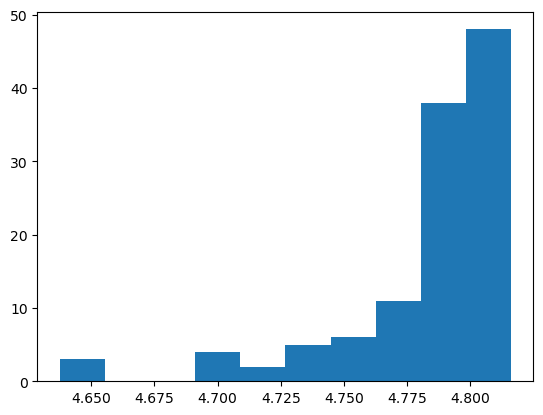

In [35]:
b=plt.hist(vals100)

In [ ]:
T=1
r=0.03
sigma=0.15
K=100
S0=110
N=[10+i*5 for i in range(0,39)]
M=100000
k=[2,3,4]

vals110=[]
for t in N:
    bs=[]
    for b in k:
        
        lsm=LSM(T,r,sigma,K,S0,t,M,b)
        vals110.append(lsm)
        bs.append(lsm)
    print(f"Average for {t} is {np.mean(bs)}")
ans110=np.mean(vals110)

Average for 10 is 1.7675281920690977
Average for 15 is 1.786927153184929
Average for 20 is 1.7979784194699888
Average for 25 is 1.8046192064752489
Average for 30 is 1.8099606677220577
Average for 35 is 1.8132335803217885
Average for 40 is 1.820040625619667
Average for 45 is 1.8224242463665252
Average for 50 is 1.8247082787471725
Average for 55 is 1.8267361184301751
Average for 60 is 1.8265170305167029
Average for 65 is 1.8260285820762308
Average for 70 is 1.828757983272858
Average for 75 is 1.8288297775531952
Average for 80 is 1.8287139289533194
Average for 85 is 1.8289318668666301
Average for 90 is 1.8307790203985144
Average for 95 is 1.8315261188303715
Average for 100 is 1.833919428582069
Average for 105 is 1.8349090826681014
Average for 110 is 1.8363427258129876
Average for 115 is 1.8356114781353188
Average for 120 is 1.837199718112001
Average for 125 is 1.8371513911080541
Average for 130 is 1.8360784782570703
Average for 135 is 1.8358610440583396
Average for 140 is 1.83655876345594

In [ ]:
b=plt.hist(vals110)

### Notes
- Cross Checking against Matlab code; identical seeds (random number generation)
- Note Gustaffson samples from the normal distribution -> which is not the default implementation in numpy!!
